# ITCR - Sede Interuniversitaria de Alajuela

## Proyecto 3 spark

### Estudiantes: Roy Chavarría Garita - Jonder Hernández Gutiérrez

## Objetivo del proyecto 
Aplicar técnicas para extracción, transformación y carga a datos de la
vida cotidiana generados por instituciones en Costa Rica, calcular estadísticas sobre los
datos y visualizarlas por medio de Spark.

Objetivos específicos

- Poner en práctica el conocimiento visto en clase sobre SparkSQL aplicado a datos
de Costa Rica

- Diseñar e implementar mecanismos que permitan analizar los datos por medio de
estadísticas y visualización utilizando Spark.

## Descripción general del sistema. 
Este proyecto busca que los estudiantes se expongan a la complejidad que implica
obtener e integrar datos reales que provienen de múltiples fuentes. Para el ejercicio se
utilizarán datos de criminalidad en Costa Rica combinados con datos socio-económicos
asociados a los cantones del país. Los datos deberán ser preprocesados e integrados de
manera que puedan ser utilizados para propósitos analíticos.
Los datos provienen de dos instituciones nacionales, a saber:
 1. Instituto Nacional de Estadística y Censos de Costa Rica (INEC): El INEC es la
institución encargada a nivel nacional de la generación y divulgación de datos
estadísticos obtenidos por medio de censos, encuestas y otros estudios sobre
demografía, economía y otros. Al igual que en el OIJ, los datos están disponibles
por distrito. Los datos fueron generados por el INEC como resultado del censo
realizado en el país en el año 2011. Los datos están disponibles en [1].
 2. Organismo de Investigación Judicial (OIJ): El OIJ publica datos sobre criminalidad
en Costa Rica que tienen como fuente las denuncias interpuestas directamente
ante esta entidad nacional. Los datos recopilados por el OIJ están disponibles por
1
provincia, cantón y distrito (deben ser bajados como hoja electrónica para contar
con el dato de distrito). Los datos están disponibles en [2].

## Dependencias

In [1]:
# Bibliotecas requeridas para el proyecto

import pandas as pd
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import date, timedelta, datetime
import time

from pyspark.sql.types import *

# Para trabahar con tipos de letras
from openpyxl import load_workbook
from openpyxl.styles import Font, Color, Alignment, Border, Side, colors

# Me ayudará con excel
import xlrd

# Esto me ayuda con remplazo usando regex
from pyspark.sql.functions import regexp_replace

# Estos sirven para quitar espacios en blanco de las palabras
from pyspark.sql.functions import ltrim,rtrim,trim
from pyspark.sql.functions import length,col
import pyspark.sql.functions as F
import quinn

# Esta es la librería para los gráficos
import matplotlib.pyplot as plt

from openpyxl import load_workbook
from pandas import read_excel

from pyspark.sql import SparkSession, Row, dataframe

# Generar valores enteros random
from random import seed
from random import randint
from random import random

import findspark
SPARK_PATH = '/opt/spark/'
findspark.init(SPARK_PATH)

print("Terminado correctamente")

Terminado correctamente


## Creamos una sesión de spark y guardamos datos de la conexión con postgres

In [2]:
#Guardo la ruta en una variable para trabajarla más facilmente
#datos_oij = "/home/estudiante/Escritorio/proyecto3/datos_oij.xls"
#datos_inec = "/home/estudiante/Escritorio/proyecto3/datos_inec.xls"

#Ingresamos los datos de nuestra instancia de postgres, proyecto3 es el nombre de la base de datos
POSTGRESQL_URL = "jdbc:postgresql://localhost/proyecto3"
POSTGRESQL_USER = "postgres"
POSTGRESQL_PASSWORD = "postgres"

# Descripción: creo una sesion de spark para trabajar
# Salida: La sesion de spark
def create_spark_session():
    """
    This function builds a Spark Session
    return the main entry of a Spark DataFrame
    """
    spark = SparkSession \
      .builder \
      .appName("Basic JDBC pipeline") \
      .config("spark.driver.extraClassPath", "postgresql-42.1.4.jar") \
      .config("spark.executor.extraClassPath", "postgresql-42.1.4.jar") \
      .getOrCreate()
    return spark

#Creación de una session de spark
spark = create_spark_session()

print("Terminado correctamente")

Terminado correctamente


## Leemos los archivos del censo y del oij

In [3]:
#Con skiprow le indico que me lea de la fila numero 4 en adelante 
#y con usecols le indico el rango de columnas de mi interés, todo esto solo para los datos del censo
xls_censo = pd.read_excel('datos_censo.xlsx', skiprows = 9, usecols=range(1,8))

#Limpio el xls_censo quitandole las filas que están en blanco
xls_censo = xls_censo.dropna()

#Esto me cambia el nombre de las columnas de los datos del censo
xls_censo.rename(columns={'Unnamed: 1':'provinciaCantonYDistrito',
                          'Unnamed: 2':'población_de_15_años_y_más',
                          'Unnamed: 3':'tasa_neta_de_participación',
                          'Unnamed: 4':'tasa_de_ocupación',
                          'Unnamed: 5':'tasa_de_desempleo_abierto',
                          'Unnamed: 6':'porcentaje_de_población_económicamente_inactiva',
                          'Unnamed: 7':'relación_de_dependencia_económica'},inplace=True)


#Leemos los datos del oij
xls_oij = pd.read_excel('datos_oij.xlsx')


#Creamos los dataframe del oij y del censo
dfPandas_censo = pd.DataFrame(xls_censo)
dfPandas_oij = pd.DataFrame(xls_oij)

#print(dfPandas_censo)
#print(dfPandas_oij)
#Defino el tipo de datos, que va a tener el datafame_censo de spark, porque si no me da error al crear el frame en spark
mySchema = StructType([ StructField("provinciaCantonYDistrito", StringType(), True)\
                       ,StructField("población_de_15_años_y_más", FloatType(), True)\
                       ,StructField("tasa_neta_de_participación", FloatType(), True)\
                       ,StructField("tasa_de_ocupación", FloatType(), True)\
                       ,StructField("tasa_de_desempleo_abierto", StringType(), True)\
                       ,StructField("porcentaje_de_población_económicamente_inactiva", FloatType(), True)\
                       ,StructField("relación_de_dependencia_económica", FloatType(), True)])

# Creamos el spark dataframe
df_censo = spark.createDataFrame(dfPandas_censo, schema=mySchema)
df_oij = spark.createDataFrame(dfPandas_oij)

#df_censo.show()

print("Terminado correctamente")

Terminado correctamente


## Función que elimine los espacios en blanco de la columna distrito para usarse en ambos conjuntos de datos.

In [4]:
#ESta funcion muestra el antes y el despues de aplicar la funcion de quitar los espacios dentro del censo

# Descripción Muestra el largo de del contenido de una columna de un dataframe
# Entrada: 
#   df: Dataframe a modificar la columna
#   colum: nombre de la columna a modificar
#   alias: alias de la columna nueva a mostrar
#   cant: cantidad de elementos a mostrar y contar su contenido
def mostrar_largo_celdas(df, colum, alias, cant):
    df.select(length(col(colum)).alias(alias)).show(cant)

    

#Verifico que tengan los espacios en blanco
mostrar_largo_celdas(df_censo, "provinciaCantonYDistrito", "length_with_whitespace_censo", 5)
mostrar_largo_celdas(df_oij, "Distrito", "length_with_whitespace_oij", 5)


# Descripción Elimina los espacios en blanco de una columna de un dataframe
# Entradas:
#   df: Dataframe a modificar la columna
#   colum: nombre de la columna a modificar
# Salida: El dataframe con la columna modificada
def eliminar_espacios_en_blanco(df, colum):
    df = df.withColumn(colum,quinn.remove_all_whitespace(col(colum)))
    return df

#Elimino los espacios    
df_censo = eliminar_espacios_en_blanco(df_censo, "provinciaCantonYDistrito")
df_oij = eliminar_espacios_en_blanco(df_oij, "Distrito")


#Verifico que se eliminaron los espacios en blanco en las dos columnas(censo y oij) correctamente
mostrar_largo_celdas(df_censo, "provinciaCantonYDistrito", "length_without_whitespace_censo", 5)
mostrar_largo_celdas(df_oij, "Distrito", "length_without_whitespace_oij", 5)
                  
    
#df_censo.show(10)
print("Terminado correctamente")

+----------------------------+
|length_with_whitespace_censo|
+----------------------------+
|                           8|
|                           8|
|                          17|
|                          15|
|                          18|
+----------------------------+
only showing top 5 rows

+--------------------------+
|length_with_whitespace_oij|
+--------------------------+
|                        21|
|                         9|
|                         9|
|                         8|
|                         9|
+--------------------------+
only showing top 5 rows

+-------------------------------+
|length_without_whitespace_censo|
+-------------------------------+
|                              7|
|                              7|
|                              6|
|                              6|
|                              8|
+-------------------------------+
only showing top 5 rows

+-----------------------------+
|length_without_whitespace_oij|
+--------------

## Una función que convierta a minúsculas el contenido de la columna distrito para usarse en ambos conjuntos de datos.

In [5]:
# Descripción: Muestra los datos de una columna en un dataframe
# Entradas:
#   df: Dataframe a mostrar
#   colum: nombre de la columna a mostrar
#   alias: Alias de la columna del resultado
#   cant: cantidad de elementos a mostrar
def mostrar_datos_celdas(df, colum, alias, cant):
    df.select(col(colum)).alias(alias).show(cant)
    
#Verifico que algunos datos estén con mayusculas
mostrar_datos_celdas(df_censo, "provinciaCantonYDistrito", "Dates_with_upperCase_censo", 5)
mostrar_datos_celdas(df_oij, "Distrito", "Dates_with_upperCase_oij", 5)

# Descripción: Convierte los datos de una columna en un dataframe a minuscula
# Entradas:
#   df: Dataframe a modificar la columna
#   colum: nombre de la columna a modificar
# Salida: El dataframe con la columna modificada
def convertir_celda_a_minuscula(df, colum):
    df = df.withColumn(colum,lower(col(colum)))
    return df
# Convierto a minisculas las columnas "provinciaCantonYDistrito" y "Distrito" de los datos del OIJ y del INEC respectivamente
df_censo = convertir_celda_a_minuscula(df_censo, "provinciaCantonYDistrito")
df_oij = convertir_celda_a_minuscula(df_oij, "Distrito")

# Muestro los datos para verificar que se realizó el cambio correctamente
mostrar_datos_celdas(df_censo, "provinciaCantonYDistrito", "Dates_without_upperCase_censo", 5)
mostrar_datos_celdas(df_oij, "Distrito", "Dates_without_upperCase_oij", 5)

print("Terminado correctamente")

+------------------------+
|provinciaCantonYDistrito|
+------------------------+
|                 SanJosé|
|                 SanJosé|
|                  Carmen|
|                  Merced|
|                Hospital|
+------------------------+
only showing top 5 rows

+------------------+
|          Distrito|
+------------------+
|LLANOSDESANTALUCIA|
|          SANPEDRO|
|          SANPEDRO|
|          HOSPITAL|
|          TRESRIOS|
+------------------+
only showing top 5 rows

+------------------------+
|provinciaCantonYDistrito|
+------------------------+
|                 sanjosé|
|                 sanjosé|
|                  carmen|
|                  merced|
|                hospital|
+------------------------+
only showing top 5 rows

+------------------+
|          Distrito|
+------------------+
|llanosdesantalucia|
|          sanpedro|
|          sanpedro|
|          hospital|
|          tresrios|
+------------------+
only showing top 5 rows

Terminado correctamente


## Una función que devuelva la lista de distritos del conjunto de datos del OIJ que no coinciden con ningún distrito del conjunto de datos del Inec

In [6]:
# Descripción: Lista los distritos del conjunto de datos del OIJ que no coinciden con ningun conjunto de datos del INEC
# Salida: Una tabla que contiene en la columna "Distrito" los datos del OIJ que no coinciden con los datos del INEC
def listarDistritosDelOijSinCoincidenciasConCenso():    
    #Realizo un lef join de los datos del oij con los datos del inec
    left_join = df_oij.join(df_censo, df_oij.Distrito == df_censo.provinciaCantonYDistrito, how='left')
    #Elimino los datos que son nulos que aparecieron con el left join
    left_join = left_join.filter(df_censo.provinciaCantonYDistrito.isNull())
    #Muestro los datos resultantes
    left_join = left_join.select(col("Distrito")).alias("Distritos")
    return left_join
listarDistritosDelOijSinCoincidenciasConCenso().distinct().show(30)

+-----------+
|   Distrito|
+-----------+
|  canonegro|
|    rioazul|
|       para|
|      colon|
|   guapiles|
|    guacimo|
|   canalete|
|     puraba|
|      cajon|
|      drake|
|      belen|
|  sanandres|
| reventazón|
|    lalegua|
|     granja|
|canasdulces|
|desconocido|
|     jardin|
|   rionuevo|
|  laamistad|
| sannicolas|
|   tarcoles|
|    alegria|
|    patarra|
| santamaria|
|   leonxiii|
|    caldera|
|     cortes|
|    palmera|
| sanjoaquin|
+-----------+
only showing top 30 rows



## Una función que devuelva la cantidad de registros en el conjunto de datos del OIJ que no coinciden con ningún distrito del conjunto de datos del Inec.

In [7]:
# Descripcion: Cuenta la cantidad de distritos en los datos del oij que no coinciden con los datos del INEC
# Salida: Un numero que es la cantidad de distritos no coincidentes
def cantidadDistritosDelOijSinCoincidenciasConCenso():
    #Nada mas retorno la cantidad de datos de la funcion cantidadDistritosDelOijSinCoincidenciasConCenso
    return listarDistritosDelOijSinCoincidenciasConCenso().count()
cantidadDistritosDelOijSinCoincidenciasConCenso()

4800

## Edite, utilizando SparkSQL, los nombres de los distritos del Inec para que coincidan con algunos de los del OIJ. 

In [8]:
# Descripción: Quito los acentos y 'ñ' de los datos de una columna en un dataframe
# Entrada:
#   df: Dataframe a modificar la columna
#   colum: nombre de la columna a modificar
# Salida: El dataframe con la columna modificada
def quitar_acentos(df, nombre_columna):
    df= df.withColumn(nombre_columna, regexp_replace(nombre_columna, "á", "a"))
    df= df.withColumn(nombre_columna, regexp_replace(nombre_columna, "é", "e"))
    df= df.withColumn(nombre_columna, regexp_replace(nombre_columna, "í", "i"))
    df= df.withColumn(nombre_columna, regexp_replace(nombre_columna, "ó", "o"))
    df= df.withColumn(nombre_columna, regexp_replace(nombre_columna, "ú", "u"))
    df= df.withColumn(nombre_columna, regexp_replace(nombre_columna, "ñ", "n"))
    return df

#Quito acentos y ñs de los datos del oij para que los datos calzen
df_censo = quitar_acentos(df_censo, "provinciaCantonYDistrito")
#df_oij = quitar_acentos(df_oij, "Distrito")

#Observamos que ya son menos los archivos que no calzan
listarDistritosDelOijSinCoincidenciasConCenso().distinct().show()
print(cantidadDistritosDelOijSinCoincidenciasConCenso())


#df_censo.toPandas().to_csv('df_censo.csv')
#df_oij.toPandas().to_csv('df_oij.csv')
print("Terminado correctamente")

+------------------+
|          Distrito|
+------------------+
|          canalete|
|             drake|
|        reventazón|
|           lalegua|
|            granja|
|       desconocido|
|         laamistad|
|           caldera|
|            cortes|
|           palmera|
|sanjosedelamonta?a|
|       santaisabel|
|           general|
|         horquetas|
|             ceiba|
|         cabeceras|
|        elchirripo|
|           mastate|
|           fortuna|
|          labrador|
+------------------+
only showing top 20 rows

775
Terminado correctamente


# Guarde los datos limpios del Inec y del OIJ en una base de datos en PostgreSQL. 

In [15]:
# Descripción: Guarda los datos en PostgreSQL
# Entradas:
#   spark_df: Dataframe a guardar
#   table_name: Nombre de la tabla donde se guardara en PostgreSQL
def write_spark_df_to_db(spark_df, table_name):
    """
    This function writes Spark dataframe to DB
    """
    spark_df \
        .write \
        .format("jdbc") \
        .mode('overwrite') \
        .option("url", POSTGRESQL_URL) \
        .option("user", POSTGRESQL_USER) \
        .option("password", POSTGRESQL_PASSWORD) \
        .option("dbtable", table_name) \
        .save()
    
write_spark_df_to_db(df_censo, "Datos_censo")
write_spark_df_to_db(df_oij, "Datos_oij")

print("Terminado correctamente")

Terminado correctamente


# Visualización de datos. La visualización se realizará por medio del software Spark.

## 1. Compare la cantidad de delitos y la tasa de ocupación para los 10 distritos con más delitos en el país. 

Terminado correctamente
Comparación entre la cantidad de delitos y la tasa de ocupación de los 10 distritos con mas delitos


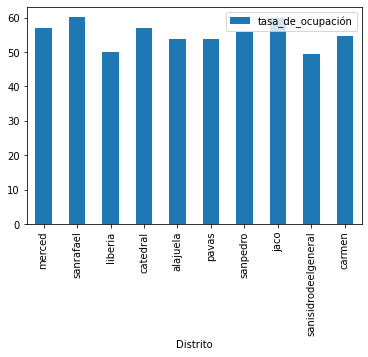

In [10]:
# Esto es para probar en excel:
#              =CONTAR.SI(L2:L34357; "HEREDIA")

# Descripción: Gráfica una comparación entre la cantidad de delitos y la tasa de ocupación 
#              de los 10 distritos con mas delitos
def grafico_1():
    #GroupBy me agrupa los datos dependiendo de otra columna, el agg me los cuenta y el sort los ordena
    eje_x = df_oij.groupby('Distrito').agg(count('Provincia').alias('Cantidad')).sort(desc("cantidad"))
    
    #Le digo que me muestre solo las primeras 10 provincias, me brinco la primera porque es "desconocido"
    eje_x = eje_x.collect()[1:11] 

    #El anterior paso me desconvierte el data frame, entonces lo vuelvo a convertir a spark
    eje_x = spark.createDataFrame(eje_x)

    #Muetro el resultado
    #eje_x.show()



    #Selecciono las columnas de mi interés
    eje_y = df_censo.select('tasa_de_ocupación','provinciaCantonYDistrito')

    #Realizo un join para unir los datos del eje_x y del eje_y, esto para tenerlos en una sola tabla
    join_x_con_y = eje_x.join(eje_y,eje_x.Distrito == eje_y.provinciaCantonYDistrito)

    #join_x_con_y.show()

    #Esto para que me ordene de mayor a menor los porcentajes de tasa_de_ocupación
    join_x_con_y = join_x_con_y.sort(desc("tasa_de_ocupación"))

    #Elimino los datos que están duplicados, producto del join
    join_x_con_y = join_x_con_y.select('Distrito','Cantidad','tasa_de_ocupación').dropDuplicates(['Distrito']).orderBy('Cantidad', ascending=False)

    #join_x_con_y.show()

    #ESTO ES PARA El minimo y máximo del eje x,y.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    #Rayas de fondo al grafico con .grid()
    grafico1 = join_x_con_y.toPandas().plot("Distrito",["tasa_de_ocupación"], kind = 'bar')
    
    
    

#Muestro los datos de forma gráfica
print("Terminado correctamente")
print("Comparación entre la cantidad de delitos y la tasa de ocupación de los 10 distritos con mas delitos")
grafico_1()

## 2. Grafique la cantidad de delitos por día de la semana para el distrito con más delitos.

Terminado correctamente
Comparación entre la cantidad de delitos por dia de la semana para el distrito con más delitos.
Distrito con más delitos: merced
+-----------------+------------+
|dias_de_la_semana|Cant_Delitos|
+-----------------+------------+
|          Viernes|          82|
|           Sábado|          76|
|            Lunes|          75|
|        Miércoles|          72|
|           Martes|          53|
|          Domingo|          50|
|           Jueves|          46|
+-----------------+------------+



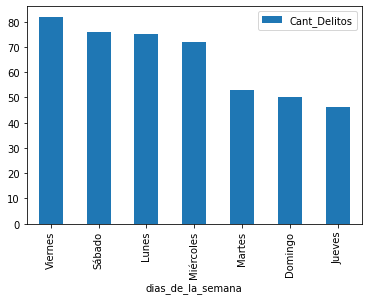

In [11]:
# Descripción: Gráfica una comparación entre la cantidad de delitos por dia de la semana 
#              para el distrito con más delitos.
def grafico_2():

    #Pimero saco el distrito con mas delitos
    distrito_mas_delitos = df_oij.groupby('Distrito').agg(count('Provincia').alias('Cantidad')).sort(desc("cantidad"))
    distrito_mas_delitos = distrito_mas_delitos.collect()[1:2] 
    distrito_mas_delitos = spark.createDataFrame(distrito_mas_delitos)
    #distrito_mas_delitos.show()

    #Nombre del distrito con más delitos
    distrito = (distrito_mas_delitos.toPandas())['Distrito'][0]
    
    print("Distrito con más delitos: "+ distrito)

    #Elimino el rsto de distritos que no me interesan y los datos que no me interesan
    delitos_distrito = df_oij.filter(df_oij['Distrito'] == distrito)


    #Selecciono las columnas de mi interés
    delitos_distrito = delitos_distrito.select('Distrito','Fecha', 'Delito')

    #Agrego una nueva columna llaamada dias_de_la_semana que me va a agarra la fecha y va a convertirla
    #a un dia de la semana
    delitos_distrito = delitos_distrito.withColumn("dias_de_la_semana", date_format(col("Fecha"), "EEEE"))
    #delitos_distrito.show()

    #Cuento los delitos por día
    #delitos_distrito = delitos_distrito.groupby('dias_de_la_semana').agg(count('Delito').alias('Cant_Delitos'))
    #delitos_distrito.show()

    #Muetro el gráfico con los datos solicitados
    
    nombre_columna = "dias_de_la_semana";
    delitos_distrito = delitos_distrito.groupby('dias_de_la_semana').agg(count('Delito').alias('Cant_Delitos')).orderBy(desc("Cant_Delitos"))
    
    # Convierte los dias de ingles a español
    delitos_distrito = delitos_distrito.withColumn(nombre_columna,regexp_replace(nombre_columna, "Monday", "Lunes"))
    delitos_distrito = delitos_distrito.withColumn(nombre_columna,regexp_replace(nombre_columna, "Tuesday", "Martes"))
    delitos_distrito = delitos_distrito.withColumn(nombre_columna,regexp_replace(nombre_columna, "Wednesday", "Miércoles"))
    delitos_distrito = delitos_distrito.withColumn(nombre_columna,regexp_replace(nombre_columna, "Thursday", "Jueves"))
    delitos_distrito = delitos_distrito.withColumn(nombre_columna,regexp_replace(nombre_columna, "Friday", "Viernes"))
    delitos_distrito = delitos_distrito.withColumn(nombre_columna,regexp_replace(nombre_columna, "Saturday", "Sábado"))
    delitos_distrito = delitos_distrito.withColumn(nombre_columna,regexp_replace(nombre_columna, "Sunday", "Domingo"))
    delitos_distrito.show()
    
    delitos_distrito.toPandas().plot("dias_de_la_semana","Cant_Delitos", kind = 'bar')#.set(ylim=(0,200))

print("Terminado correctamente")
print("Comparación entre la cantidad de delitos por dia de la semana para el distrito con más delitos.")
grafico_2()

## 3. Grafique la cantidad de delitos por tipo y por distrito. Es decir, para el distrito seleccionado se debe graficar la cantidad de delitos por tipo

Terminado correctamente
Cantidad de delitos por tipo del distrito de San José
Distrito de: sanjose


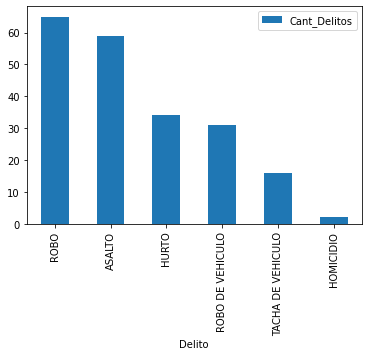

In [12]:
# Descripción: Quito los acentos, 'ñ' y convierto a minuscula los datos de una columna en un dataframe
# Entrada:
#   df: Dataframe a modificar
#   colum: nombre de la columna a modificar
# Salida: El dataframe con la columna modificada
def convertir_palabra(palabra):
    palabra = palabra.lower()
    palabra = palabra.replace(' ','')
    palabra = palabra.replace('á', 'a')
    palabra = palabra.replace('é', 'e')
    palabra = palabra.replace('í', 'i')
    palabra = palabra.replace('ó', 'o')
    palabra = palabra.replace('ú', 'u')
    return palabra
# Descripción: Gráfica la cantidad de delitos por tipo de un distrito
# Entradas:
#   nombre_distrito: nombre del distrito a mostrar la cantidad de delitos por tipo
def grafico_3(nombre_distrito):
    #Limpio el nombre del distrito
    nombre_distrito = convertir_palabra(nombre_distrito)
    print("Distrito de: "+nombre_distrito)
    #Saco todos los datos que coincidan con el distrito 
    delitos_por_distrito = df_oij.filter(df_oij.Distrito == nombre_distrito)

    #Cuento los delistos dependiendo del tpo, dentro de ese distrito
    delitos_por_tipo = delitos_por_distrito.groupby('Delito').agg(count('Delito').alias('Cant_Delitos')).orderBy(desc("Cant_Delitos"))

    #Muestro los datos
    delitos_por_tipo.toPandas().plot("Delito","Cant_Delitos", kind = 'bar')

print("Terminado correctamente")
print("Cantidad de delitos por tipo del distrito de San José")
grafico_3('san jose')

## 4. Grafique la cantidad de delitos por sexo para todo el conjunto de datos.

Terminado correctamente
Cantidad de delitos por sexo


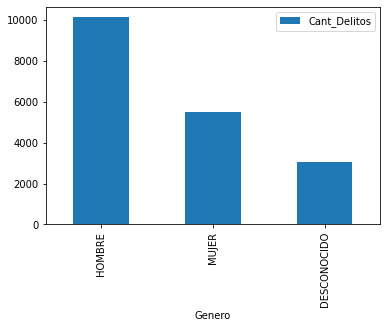

In [13]:
# Descripción: Gráfica la cantidad de delitos por sexo para todo el conjunto de datos
def grafico_4():
    #Aqui nada más cuento la cantidad de delitos que hay por generos
    delitos_por_genero = df_oij.groupby('Genero').agg(count('Delito').alias('Cant_Delitos')).orderBy(desc('Cant_Delitos'))
    delitos_por_genero.toPandas().plot("Genero","Cant_Delitos", kind = 'bar')
print("Terminado correctamente")
print("Cantidad de delitos por sexo")
grafico_4()

## 5. Proponga una visualización de su interés.

Terminado correctamente
Los 10 distritos con más Asaltos y su cantidades


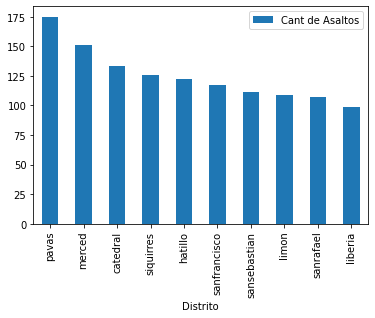

In [14]:
# Descripción: Gráfica los 10 distritos con mas Asaltos
def grafico_5():
    asaltos = df_oij.filter(df_oij.Delito == "ASALTO")

    #Cuento los delistos dependiendo del tpo, dentro de ese distrito
    delitos_por_distrito = asaltos.groupby('Distrito').agg(count('Distrito').alias('Cant de Asaltos')).orderBy(desc("Cant de Asaltos"))
    
    delitos_por_distrito = delitos_por_distrito.collect()[1:11] 

    #El anterior paso me desconvierte el data frame, entonces lo vuelvo a convertir a spark
    delitos_por_distrito = spark.createDataFrame(delitos_por_distrito)
    
    delitos_por_distrito.toPandas().plot("Distrito","Cant de Asaltos", kind = 'bar')
    #eje_x.show()
print("Terminado correctamente")
print("Los 10 distritos con más Asaltos y su cantidades")
grafico_5()


# Conclusiones
- Basado en la información proporcionada por el primer gráfico, se concluye que hay una relación en la cantidad de delitos dento de un distrito, deacuerdo a la taza de ocupación del mismo. Lo anterior significa que mientras más baja la taza de desocupación, mas alta es la cantidad de delitos.

- Del gráfico número dos se concluye que en el distrito con más delitos, que en este caso es hospital, el día donde hay mas altercados de estos son los sábados.

- Del gráfico número cuatro se concluye que la mayoría de delitos son realizados por personas mayores de edad.

- Del gráfico número cinco, se concluye que la mayor cantidad de delitos de asaltos en el distrito de Pavas.

# Referencias

Instituto Nacional de Estadísticas y Censos (2011). Censo 2011: Indicadores
económicos, según provincia, cantón y distrito. Recuperado de
http://inec.cr/documento/censo-2011-indicadores-economicos-segun-provincia-canton-ydistrito

Organismo de Investigación Judicial (2018). Estadísticas poiciales. Recuperado de
https://sitiooij.poder-judicial.go.cr/index.php/apertura/transparencia/estadisticas-policiales

Spark Groupby Example with DataFrame. Recuperado de
https://sparkbyexamples.com/spark/using-groupby-on-dataframe/